## Confidence interval with known population stddev

- Suppose we some metric `M` we want to estimate. This could be anything, but simplicity, let's consider `M` to be the mean of a population
    - To estimate `M`, we take repeated samples of size `n` of the population `k` times
    - This produces estimates $\bar{x} = \left \{ x_1, x_2, ... x_n \right \}$
    - The confidence interval is defined as the smallest range of values $[a, b]$ such that at least $\alpha$% of the samples $\bar{x}$ lie within this interval
    - Intuitively, we want $\alpha$% of the $\bar{x}$ observation to lie in $[a,b]$
    - $\alpha$ is usually 95%

- Recall that by C.L.T, for repeated samples of size `n`, $\bar{x} \sim N(\mu_{\bar{x}}, \frac{\sigma_{\bar{x}}^2}{n})$
    - i.e. The larger your sample size, the closer your sample means are to the population mean, and the smaller your confidence interval

- Since we know that $\bar{x} \sim N(\mu_{\bar{x}}, \frac{\sigma_{X}^2}{n})$, $\frac{\bar{x} - \mu_{\bar{x}}}{\sigma} = \Zeta \sim N(0, 1)$
- For a standard gaussian, 95% of all possible values are contained between -1.96 and 1.96. These are known as the **critical values** of 95% confidence interval
- This also means that, for any given set of estimates $\bar{x}$, the 95% confidence interval is simply given by $[-1.96 * \sigma_{x}, 1.96 * \sigma_{x}]$
    - $\pm1.96 * \sigma_{x}$ is also known as the **Margin of Error** (MOE)
    - Note that $\sigma_{x}$ here is the **population** standard deviation, which we will assume is known for now
- Let's prove that, when taking multiple samples of size $n$ from a population, we will end up with the confidence intervals at computed above

In [129]:
import numpy as np
import matplotlib.pyplot as plt

binomial_outcomes = np.array([0,1])
p = 0.6
population_size = 100_000

true_population = np.random.choice(binomial_outcomes, p=[1-p,p], size=population_size)
population_mean = np.mean(true_population)
population_variance = np.var(true_population)
population_stddev = np.std(true_population)
print(f'population_mean: {population_mean} || population_variance: {population_variance} || population_stddev: {population_stddev}')

population_mean: 0.60151 || population_variance: 0.23969571989999996 || population_stddev: 0.48958729548467655


In [130]:
## Suppose we don't know `p`. We take repeated samples from the population to estimate `p`
def get_samples_from_population(true_population, sample_size: int, sample_count: int):
    samples = {
        'sample_size': sample_size,
        'samples': [np.random.choice(true_population, sample_size) for _ in range(sample_count)]
    }
    return samples

def get_sample_mean_distribution(samples) -> dict:
    sample_means = {
        'sample_size': samples.get('sample_size'),
        'means': [np.mean(x) for x in samples.get('samples')]
    }
    return sample_means

repeat_samples_large=get_samples_from_population(true_population, sample_size=1000, sample_count=10_000)
repeat_samples_medium=get_samples_from_population(true_population, sample_size=200, sample_count=10_000)
repeat_samples_small=get_samples_from_population(true_population, sample_size=50, sample_count=10_000)

repeat_samples_large_means=get_sample_mean_distribution(repeat_samples_large)
repeat_samples_medium_means=get_sample_mean_distribution(repeat_samples_medium)
repeat_samples_small_means=get_sample_mean_distribution(repeat_samples_small)

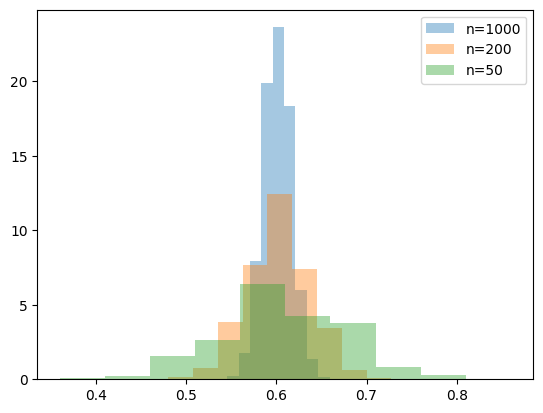

In [131]:
'''
We know that as sample size increases, we have a tighter and tighter estimate of the population mean `p`. This is a visual proof
'''
def plot_sample_means(repeat_samples_means):
    plt.hist(repeat_samples_means.get('means'), alpha=0.4, density=True, label=f'n={repeat_samples_means.get("sample_size")}')

plot_sample_means(repeat_samples_large_means)
plot_sample_means(repeat_samples_medium_means)
plot_sample_means(repeat_samples_small_means)
plt.legend()

In [132]:
'''
Let's think about what the standard errors are for each of the distributions generated above
For a bernoulli process, population variance is p * (1-p). We divide this by sqrt(sample_size)
'''
def compute_standard_error_of_mean(samples, population_mean):
    n = samples.get('sample_size')
    return np.sqrt(p * (1-p) / n)
theoretical_standard_error_of_mean_large = compute_standard_error_of_mean(repeat_samples_large, population_mean)
theoretical_standard_error_of_mean_medium = compute_standard_error_of_mean(repeat_samples_medium, population_mean)
theoretical_standard_error_of_mean_small = compute_standard_error_of_mean(repeat_samples_small, population_mean)
print(f'Large sample: {theoretical_standard_error_of_mean_large} || Med Sample: {theoretical_standard_error_of_mean_medium} || Small sample: {theoretical_standard_error_of_mean_small}')

Large sample: 0.015491933384829668 || Med Sample: 0.034641016151377546 || Small sample: 0.06928203230275509


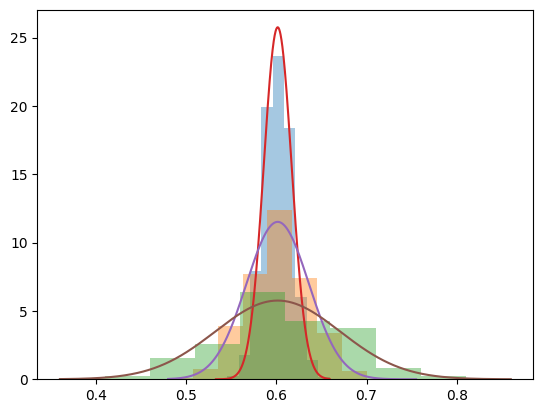

In [133]:
'''
Having derived the theoretical standard error of the sample means, we can compare the actual distribution
of mean values to see how well they match up
'''
import scipy

## Plot actual mean values as histogram
plot_sample_means(repeat_samples_large_means)
plot_sample_means(repeat_samples_medium_means)
plot_sample_means(repeat_samples_small_means)

def plot_normal_distrib(sample, sample_means, population_mean):
    ## Plot normal distribution with theoretical mean `p` and theoretical standard error
    x = np.linspace(min(sample_means.get('means')), max(sample_means.get('means')), 500)
    y = scipy.stats.norm.pdf(x, population_mean, compute_standard_error_of_mean(sample, population_mean))
    plt.plot(x,y)

plot_normal_distrib(repeat_samples_large, repeat_samples_large_means, population_mean)
plot_normal_distrib(repeat_samples_medium, repeat_samples_medium_means, population_mean)
plot_normal_distrib(repeat_samples_small, repeat_samples_small_means, population_mean)

In [189]:
'''
The above confirms that the distribution of sample means match up very well with their 
theoretical distribution! 

We now know that, for repeated samples with sample size `n` (i.e. 1000, 200, 20):
    - The distribution of means is **normally** distributed
    - The distribution of means is centered around the population mean 
    - The spread of the distribution of means is the population variance divided by sqrt(n)
'''
## The confidence interval formula implemented using population stddev estimated above
def get_ci_with_known_population_stddev(sample: list, confidence_level: float, population_stddev: float) -> tuple:
    critical_value = -scipy.stats.norm.ppf((1 - confidence_level)/2)
    #critical_value=1.96
    lb = (-critical_value * population_stddev/np.sqrt(len(sample))) + np.mean(sample)
    ub = (critical_value * population_stddev/np.sqrt(len(sample))) + np.mean(sample)
    return lb, ub

def get_95pct_ci_distribution(samples, population_stddev):
    ci = [get_ci_with_known_population_stddev(x, 0.95, population_stddev) for x in samples.get('samples')]
    return ci

## Get 95% CI for every sample
repeat_samples_large_ci=get_95pct_ci_distribution(repeat_samples_large, population_stddev)
repeat_samples_medium_ci=get_95pct_ci_distribution(repeat_samples_medium, population_stddev)
repeat_samples_small_ci=get_95pct_ci_distribution(repeat_samples_small, population_stddev)

In [190]:
## Let's confirm that 95% of the sample CIs contain the population mean
def check_proportion_ci_containing_true_mean(sample_ci: list, population_mean: float):
    proportion = [1 if x[0] < population_mean < x[1] else 0 for x in sample_ci]
    return np.mean(proportion)

print(check_proportion_ci_containing_true_mean(repeat_samples_large_ci, population_mean))
print(check_proportion_ci_containing_true_mean(repeat_samples_medium_ci, population_mean))
print(check_proportion_ci_containing_true_mean(repeat_samples_small_ci, population_mean))

0.9452
0.9485
0.9421


In [191]:
## Write full simulation to assure ourselves that 95% of the intervals contain the true population mean
def run_1_simulation(true_population, sample_size):
    population_mean = np.mean(true_population)
    population_stddev = np.std(true_population)

    repeat_samples=get_samples_from_population(true_population, sample_size=sample_size, sample_count=1000)
    #repeat_samples_means=get_sample_mean_distribution(repeat_samples)
    repeat_samples_ci=get_95pct_ci_distribution(repeat_samples, population_stddev)
    return check_proportion_ci_containing_true_mean(repeat_samples_ci, population_mean)

np.mean([run_1_simulation(true_population, 500) for x in range(50)])

0.95016

## Computing sample size needed

- In the above example, we established that
    - For any given sample size, the distribution of repeated draws of sample means will follow a normal distribution centered at the population mean, with standard error equal to the population standard deviation divided by the square root of the sample size
    - Using this normal distribution, we can compute a 95% confident interval for each sample using $z_{\alpha/2} * \frac{\sigma}{\sqrt{n}} + \bar{x}$, also known as the **margin of error** MOE
    - We proved that, when computing the CI in this manner for every sample, there is a 95% chance that the sample's CI will contain the true population mean

- Let's reverse the logic now
    - Instead of taking $n$ as given to compute the width of the 95% CI, we now want to fix the CI width, and find the sample size $n$ that will give us that width
    - In practise, this is quite a common ask when designing an experiment. That is, you want to know what sample size you should take such that you have a given certainty on the statistic of interest

- Using the same binomial set up, we know that population stddev is ~0.490. As such, MOE is $\frac{\pm 1.96 * 0.490} {\sqrt{n}}$. 
    - Let's suppose we want our estimate of the population mean to be within a range of $\pm 0.1$ at 95% confidence level. How big should our sample size be for this to be true? This is a simple matter of solving for $n$, which will give us 
        - $
            \frac{1.96 * 0.490}{\sqrt{n}} \approx 0.1 \\
            \frac{1.96 * 0.490}{0.1} \approx \sqrt{n} \\
            9.604 \approx \sqrt{n} \\
            n \approx 92.23 \approx 93 \\
        $

- Let's prove below that taking multiple samples of size 92 will give us a 95% CI of 0.1

In [192]:
## Using the same binomial population set up above
import numpy as np
import matplotlib.pyplot as plt

binomial_outcomes = np.array([0,1])
p = 0.6
population_size = 100_000

true_population = np.random.choice(binomial_outcomes, p=[1-p,p], size=population_size)
population_mean = np.mean(true_population)
population_variance = np.var(true_population)
population_stddev = np.std(true_population)
print(f'population_mean: {population_mean} || population_variance: {population_variance} || population_stddev: {population_stddev}')

population_mean: 0.6005 || population_variance: 0.23989975000000002 || population_stddev: 0.48979562064191634


In [222]:
binom_sample = get_samples_from_population(true_population, sample_size=93, sample_count=10_000)
binom_sample_means = get_sample_mean_distribution(binom_sample)

## Show that the true population mean lies in 95% of the sample mean +- 0.1
manual_ci = [(mean-0.1, mean+0.1) for mean in binom_sample_means.get('means')]
np.mean([1 if x[0] < population_mean < x[1] else 0 for x in manual_ci])

0.9557

## Confidence interval with unknown population stddev

- We've addressed the cases where the population stddev metrics are known. What if it is not? As you may have guessed, we can simply use the **sample** standard deviation $s$ instead of $\sigma$

- Recall that for a given sample, $\bar{x} \sim N(\mu_{X}, \frac{\sigma_{X}^2}{n})$
    - As such, $\frac{\bar{x} - \mu_{X}}{\frac{\sigma_X}{\sqrt{n}}} \sim N(0, 1)$

- If we swap out the population stddev $\sigma$ for sample stddev $s$, the distribution above is no longer normal. Instead: 
    - $\frac{\bar{x} - \mu_{X}}{\frac{s_{\bar{x}}}{\sqrt{n}}} \sim t(n-1)$
    - The statistic now follows a t-distribution with $n-1$ degrees of freedom

- What is the implication here? It means that the critical value used for a given confidence level (e.g. 1.96 at 95% confidence) should no longer be taken from the standard normal table, but from the t-table with appropriate degrees of freedom instead!

- Let's prove that using this new statistic will still give us the desired 95% confidence


In [224]:
## Using the same binomial population set up above
import numpy as np
import matplotlib.pyplot as plt

binomial_outcomes = np.array([0,1])
p = 0.6
population_size = 100_000

true_population = np.random.choice(binomial_outcomes, p=[1-p,p], size=population_size)
population_mean = np.mean(true_population)
population_variance = np.var(true_population)
population_stddev = np.std(true_population)
print(f'population_mean: {population_mean} || population_variance: {population_variance} || population_stddev: {population_stddev}')

population_mean: 0.60026 || population_variance: 0.23994793239999992 || population_stddev: 0.4898448044023739


In [230]:
## The confidence interval formula implemented using population stddev estimated above
def get_ci_with_unknown_population_stddev(sample: list, confidence_level: float) -> tuple:
    critical_value = -scipy.stats.t.ppf((1 - confidence_level)/2, df=len(sample)-1)
    lb = (-critical_value * np.std(sample)/np.sqrt(len(sample))) + np.mean(sample)
    ub = (critical_value * np.std(sample)/np.sqrt(len(sample))) + np.mean(sample)
    return lb, ub

def get_95pct_ci_distribution(samples):
    ci = [get_ci_with_unknown_population_stddev(x, 0.95) for x in samples.get('samples')]
    return ci

In [232]:
## Write full simulation to assure ourselves that 95% of the intervals contain the true population mean
def run_1_simulation(true_population, sample_size):
    population_mean = np.mean(true_population)
    population_stddev = np.std(true_population)

    repeat_samples=get_samples_from_population(true_population, sample_size=sample_size, sample_count=1000)
    #repeat_samples_means=get_sample_mean_distribution(repeat_samples)
    repeat_samples_ci=get_95pct_ci_distribution(repeat_samples)
    return check_proportion_ci_containing_true_mean(repeat_samples_ci, population_mean)

np.mean([run_1_simulation(true_population, 200) for x in range(50)])

0.94794

## Proof of Bessel's Correction

- Or in english: why do we divide sample stddev by $n-1$ instead of $n$?

- Let's first show that dividing by $n$ will not give you the result you want

In [233]:
import numpy as np
import matplotlib.pyplot as plt

binomial_outcomes = np.array([0,1])
p = 0.6
population_size = 100_000

true_population = np.random.choice(binomial_outcomes, p=[1-p,p], size=population_size)
population_mean = np.mean(true_population)
population_variance = np.var(true_population)
population_stddev = np.std(true_population)
print(f'population_mean: {population_mean} || population_variance: {population_variance} || population_stddev: {population_stddev}')

population_mean: 0.59944 || population_variance: 0.24011168639999997 || population_stddev: 0.4900119247528574


In [291]:
def get_sample_var_distribution_with_bessels(samples):
    return [np.var(x, ddof=1) for x in samples.get('samples')]

def get_sample_var_distribution_without_bessels(samples):
    return [np.var(x) for x in samples.get('samples')]

In [292]:
population_mean=np.mean(true_population)
population_stddev=np.std(true_population)
population_var=np.var(true_population)

repeat_samples=get_samples_from_population(true_population, sample_size=50, sample_count=10)
repeat_samples_var_with_bessels=get_sample_var_distribution_with_bessels(repeat_samples)
repeat_samples_var_without_bessels=get_sample_var_distribution_without_bessels(repeat_samples)

In [293]:
sample_stddev_without_bessels_correction=np.mean(repeat_samples_var_without_bessels)
sample_stddev_with_bessels_correction=np.mean(repeat_samples_var_with_bessels)

print(f"Without Bessel's Correction: {sample_stddev_without_bessels_correction}")
print(f"With Bessel's Correction: {sample_stddev_with_bessels_correction}")
print(f"Population SD: {population_var}")

Without Bessel's Correction: 0.23164
With Bessel's Correction: 0.23636734693877554
Population SD: 0.24011168639999997


In [300]:
def run_1_simulation():
    repeat_samples=get_samples_from_population(true_population, sample_size=100, sample_count=1000)
    repeat_samples_var_with_bessels=get_sample_var_distribution_with_bessels(repeat_samples)
    repeat_samples_var_without_bessels=get_sample_var_distribution_without_bessels(repeat_samples)
    sample_stddev_without_bessels_correction=np.mean(repeat_samples_var_without_bessels)
    sample_stddev_with_bessels_correction=np.mean(repeat_samples_var_with_bessels)

    # print(f"Without Bessel's Correction: {sample_stddev_without_bessels_correction}")
    # print(f"With Bessel's Correction: {sample_stddev_with_bessels_correction}")
    # print(f"Population SD: {population_var}")
    return sample_stddev_without_bessels_correction, sample_stddev_with_bessels_correction

distrib = [run_1_simulation() for _ in range(500)]
distrib_without_correction = [x for (x,_) in distrib]
distrib_with_correction = [y for (_,y) in distrib]

'''
Clearly, no matter how many samples you take, not accounting for Bessel's correction when 
calculating each sample's variance/sd will bias your estimate of population variance/sd
'''
print(np.mean(distrib_without_correction))
print(np.mean(distrib_with_correction))
print(population_var)

0.2377283256
0.24012962181818182
0.24011168639999997


- We have shown that without bessel's correction, the sample variance/stddev does not converge to the population one

- Is there a mathematical proof why this is the case? Yes!
    - Let's try to prove or disprove $E[s^2] = \sigma^2$, where $s$ is the sample stddev, and $\sigma$ is the population stddev
        - $\begin{align}
            E[s^2] &= E[\frac{1}{N} \sum_{n=1}^{N} (X_n - \bar{X})^2] \\
            &= E[\frac{1}{N} \sum_{n=1}^{N} (X_n^2 - 2X_n\bar{X} + \bar{X}^2)] \\
            &= E[\frac{1}{N} \sum_{n=1}^{N} X_n^2] - E[2\bar{X}\frac{1}{N}\sum_{n=1}^{N} X_n] + E[\frac{1}{N} \sum_{n=1}^{N} \bar{X}^2] \\
            &= E[X_n^2] - 2E[\bar{X}^2] + E[\bar{X}^2] \\
            &= E[X_n^2] - E[\bar{X}^2]
        \end{align}$
    
    - Recall that 
        - $\begin{align}
            Var(Y) &= E[Y^2] - E[Y]^2 \\
            E[Y^2] &= Var(Y) + E[Y]^2 
        \end{align}$

    - Using this relationship, we can rewrite the first result as:
        - $\begin{align}
            E[s^2] &= E[X_n^2] - E[\bar{X}^2] \\
            &= (Var(X_n) + \bar{X_n}) - (Var(\bar{X}) + \bar{X}) \\
            &= \sigma_X^2 + \mu_X - \frac{\sigma_X^2}{N} - \mu_X \\
            &= \sigma_X^2 - \frac{\sigma_X^2}{N}  \\
            &= (1- \frac{1}{N}) \sigma_X^2 \\
            &= (\frac{N-1}{N}) \sigma_X^2 \\
        \end{align}$

    - Consequently
        - $\begin{align}
            E[s^2] &= (\frac{N-1}{N}) \sigma_X^2 \\
            E[\frac{N}{N-1} s^2] &= \sigma_X^2 \\
            \frac{N}{N-1} \frac{\sum_{i=1}^{N} s^2}{N} &= \sigma_X^2 \\
            \frac{1}{N-1} \sum_{i=1}^{N} s^2 &= \sigma_X^2 
        \end{align}$